<a href="https://colab.research.google.com/github/Jitendra4Jalwaniya/BERT-fine-tuning/blob/main/bert_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. setup**

**1.1 using colab gpu for training**

In [ ]:
import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


**1.2 installing the huggingface library**

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 28.4MB/s 
     |████████████████████████████████| 3.3MB 56.1MB/s 
     |████████████████████████████████| 901kB 39.5MB/s 


**2. Loading CoLA dataset**

**2.1 Download & Extract**

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=221774594944fad7ab74187c7a369757a76757427b3e281e60ab33f51e05e860
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import wget
import os
print("Downloading dataset...")
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
if not os.path.exists('./cola_public_1.1.zip'):
  wget.download(url,'./cola_public_1.1.zip')

In [ ]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


**2.2 Parse**

In [ ]:
import pandas as pd
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv",delimiter='\t',header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
2909,l-93,0,*,That new handle detaches from the box easily.
5136,ks08,1,NaN,It's the second Monday that we get back from E...
2963,l-93,0,*,The song sang.
4912,ks08,0,*,Every essay she's written and that I've read i...
267,cj99,0,*,"We gave him enough opportunity and, sure enoug..."
6492,d_98,1,NaN,Can anyone pledge $1000?
7905,ad03,1,NaN,Jason persuaded Medea to try to run away.
4647,ks08,1,NaN,Chris was handed a note by Pat.
4615,ks08,1,NaN,John has been taken to the library.
2578,l-93,1,NaN,Tamara poured water out of the pitcher.


In [ ]:
df.loc[df.label==0].sample(5)[['sentence','label']]

,sentence,label
2602,Jessica stuffed boxes at the truck.,0
919,"Near everyone Angleton did, Dulles stood.",0
3258,Jennifer baked at the potatoes.,0
1679,It is this hat that that he was wearing is cer...,0
8244,There were killed three men.,0


In [ ]:
sentences = df.sentence.values
labels = df.label.values

**3. Tokenization & input formatting**

**3.1 BERT tokenizer**

In [ ]:
from transformers import BertTokenizer
print('loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

loading BERT tokenizer...


In [ ]:
print('Original: ',sentences[0])
print('Tokenized: ',tokenizer.tokenize(sentences[0]))
print('TokenID: ',tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
TokenID:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


**3.2 Required Formatting**

In [ ]:
'''

We are required to:

1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the “attention mask”.

BERT has two constraints:

1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

'''

'\n\nWe are required to:\n\n1. Add special tokens to the start and end of each sentence.\n2. Pad & truncate all sentences to a single constant length.\n3. Explicitly differentiate real tokens from padding tokens with the “attention mask”.\n\nBERT has two constraints:\n\n1. All sentences must be padded or truncated to a single, fixed length.\n2. The maximum sentence length is 512 tokens.\n\n'

**3.3 Tokenize Dataset**

In [ ]:
max_len =0
for sent in sentences:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent,add_special_tokens=True)
  max_len = max(max_len,len(input_ids))

print("maximum sentence length is: ",max_len)

maximum sentence length is:  47


In [ ]:
# Just in case there are some longer test sentences, I’ll set the maximum length to 64.
'''
The tokenizer.encode_plus function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special [CLS] and [SEP] tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
'''

input_ids =[]
attention_masks = []

for sent in sentences:
  encoded_dict = tokenizer.encode_plus(
      sent,
      add_special_tokens = True,
      max_length = 64,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_tensors = 'pt',        # return pytorch tensors
      truncation = True,
  )
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids,dim=0)
attention_masks = torch.cat(attention_masks,dim=0)
labels = torch.tensor(labels)

print('Original: ',sentences[0])
print('Token ID: ',input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token ID:  tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


**3.4 Training & validation split**

In [ ]:
from torch.utils.data import TensorDataset, random_split
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids,attention_masks,labels)
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset,[train_size,val_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


In [ ]:
# We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size,
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size,
)

**4. Train our classification model**

**4.1 BertForSequenceClassification**

In [ ]:
from transformers import BertForSequenceClassification, BertConfig, AdamW

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions =False,
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

**the following cell is not necessary**

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

**4.2 Optimizer & Learning Rate Scheduler**

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)

optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs =4
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader)*epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps =0,
    num_training_steps = total_steps
)

**4.3 Training Loop**

In [ ]:
import numpy as np 
def flat_accuracy(preds,labels):
  pred_flat = np.argmax(preds,axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(labels_flat==pred_flat)/len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
seed_val=42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0,epochs):
  
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0 
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
      
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()
        output = model(
            b_input_ids,
            token_type_ids = None,
            attention_mask = b_input_mask,
            labels = b_labels
        )
        loss=output.loss
        logits=output.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss/len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_masks = batch[1].to(device)
      b_labels = batch[2].to(device)
      with torch.no_grad():
        output=model(
            b_input_ids,
            token_type_ids = None,
            attention_mask = b_input_masks,
            labels = b_labels
        )
      loss=output.loss
      logits=output.logits
      total_eval_loss += loss.item()
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      total_eval_accuracy += flat_accuracy(logits,label_ids)
    
    avg_val_accuracy = total_eval_accuracy/len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss/len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    training_stats.append(
        {
            'epoch':epoch_i + 1,
            'Training_loss': avg_train_loss,
            'Valid. loss': avg_val_loss,
            'Valid. Accur': avg_val_accuracy,
            'Training time': training_time,
            'Validation time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:15.
  Batch    80  of    241.    Elapsed: 0:00:31.
  Batch   120  of    241.    Elapsed: 0:00:46.
  Batch   160  of    241.    Elapsed: 0:01:01.
  Batch   200  of    241.    Elapsed: 0:01:15.
  Batch   240  of    241.    Elapsed: 0:01:30.

  Average training loss: 0.07
  Training epcoh took: 0:01:30

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.73
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:15.
  Batch    80  of    241.    Elapsed: 0:00:30.
  Batch   120  of    241.    Elapsed: 0:00:45.
  Batch   160  of    241.    Elapsed: 0:01:00.
  Batch   200  of    241.    Elapsed: 0:01:15.
  Batch   240  of    241.    Elapsed: 0:01:29.

  Average training loss: 0.16
  Training epcoh took: 0:01:30

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.60
  Validation took: 0:00:04

======== Epoch 3 / 4 ========
Training...
 

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training_loss,Valid. loss,Valid. Accur,Training time,Validation time
epoch,,,,,
1,0.07,0.73,0.81,0:01:30,0:00:03
2,0.16,0.60,0.83,0:01:30,0:00:04
3,0.13,0.60,0.83,0:01:30,0:00:04
4,0.14,0.60,0.83,0:01:29,0:00:04


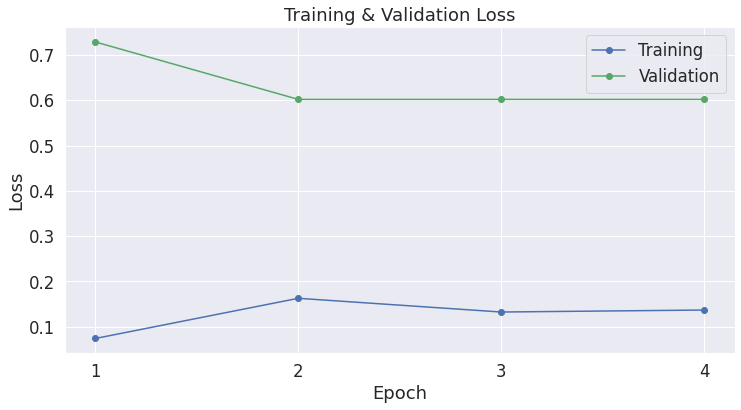

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training_loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

**5. Performance on Test Set**

**5.1. Data Preparation**

In [ ]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**5.2. Evaluate on Test Set**

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
model.eval()
predictions, true_labels = [],[]

for batch in prediction_dataloader:
  batch=tuple(t.to(device) for t in batch)
  b_input_ids,b_input_mask,b_labels = batch
  with torch.no_grad():
    outputs = model(
        b_input_ids,
        token_type_ids = None,
        attention_mask = b_input_mask
    )

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []
print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i],axis=1).flatten()
  matthews = matthews_corrcoef(true_labels[i],pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


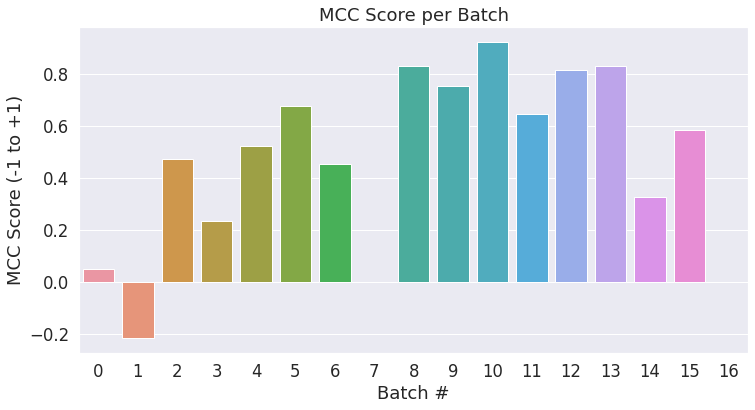

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
flat_predictions = np.concatenate(predictions,axis=0)
flat_predictions = np.argmax(flat_predictions,axis=1).flatten()
flat_true_labels = np.concatenate(true_labels,axis=0)
mcc = matthews_corrcoef(flat_true_labels,flat_predictions)
print('Total MCC: %.3f' % mcc)

Total MCC: 0.540
